## Installing and Importing Dependencies

In [ ]:
# !pip install imageio gdown
# # imageio - image input ouput karne ke kaam aata hai
# # gdown - gdown google drive se download karne ke liye kaam aata hai by using link

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip list #check versions of different libraries we are using

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [ ]:
import os # access hamari physical storage / storage
import cv2 # openCV
import tensorflow as tf
import numpy as np
from typing import List # typing annotations as list
import matplotlib.pyplot as plt
import imageio # Render a number of frames together as gif (mimsave use karke karte hai aisa)

In [ ]:
tf.config.list_physical_devices('GPU')
# this shows the presence of only 1 GPU: i.e. GPU 0

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
#to control the memory growth of GPU devices. Setting memory growth to True allows TensorFlow to allocate GPU memory as needed, rather than allocating the full GPU memory at once. This can be beneficial for avoiding memory fragmentation and ensuring efficient memory usage.

# 1. Build Data Loading Functions

In [ ]:
import gdown

In [ ]:
# using the original grid dataset, which was created for the purpose of lip reading models
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet = False) #using gdown to download the dataset from the link on google drive
gdown.extractall('data.zip') #extracting the data folder from the zip file

the data folder has 2 sub folders: align and s1. S1 has all the mpg files  and align has another folder s1 which contains it's annotations.
In the annotations "sil" means silence

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path) # load video using openCV
    frames = [] #creating a empty list, baad me frames add karte jayenge from videos (at last frames will store the video)
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame) # grayscale me convert kardenge, preprocessing easy and smooth karne ke liye
        frames.append(frame[190:236, 80:220,:]) # masking and keeping only the roi, ie the mouth region
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) std # these three lines of codes are needed to scale our lines of code

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "] # characters that might be encountered in our annotations

In [ ]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="") # encoding to numerical form (oov - out of vocabulary)
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True # invert is used to state that decoding will be inverted i.e. number to char and not char to number
) #decoding

# we first convert annotations into numbers, to find the value of losses.
# then further on we can convert them back into characters(their original format)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['v', 'i', 'r', 'a', 't'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([22,  9, 18,  1, 20])>

In [ ]:
num_to_char([22,  9, 18,  1, 20])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'v', b'i', b'r', b'a', b't'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines() # reading each of the lines of the annotated file
    tokens = [] # creating an empty list to store the alignments
    for line in lines:
        line = line.split()
        if line[2] != 'sil': # when not silence
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:] #converting character into numbers(tokens)

In [ ]:
def load_data(path: str): # to load the data i.e. video and alignment together
    path = bytes.decode(path.numpy())
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/content/data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('/content/data/alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = 's1/bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

# extracting bbal6n out of the entire path, since the alignment would have bbal6n in common
# in short getting the file_name for the load_data function

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

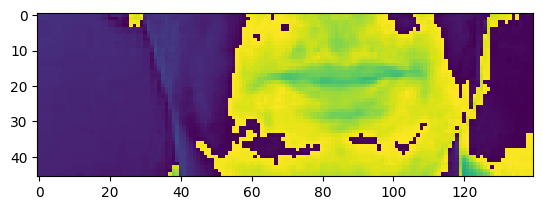

In [ ]:
plt.imshow(frames[5]) # viewing the 5th frame

In [ ]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

# decoded annotation from the numerical tokens (reduce_join is used to join strings together into one)

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64)) # py_function - kal dekhenge mainly
    return result

## 2. Create Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) # creating batches with 2 videos each
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames) # kyunki batch me 2 videos hai

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next()

In [ ]:
val[0][0].shape # val -> [ [video1, video2] , [alignment1, alignment2]] so val[0][0] likha hai

(75, 46, 140, 1)

In [ ]:
# Convert frames to uint8 and remove the extra dimension
converted_frames = np.squeeze((val[0][0] * 255).astype(np.uint8), axis=-1)

# Save the GIF
imageio.mimsave('./animation.gif', converted_frames, duration=4)

In [ ]:
# print(val[0][0].dtype)
# print(val[0][0].shape)

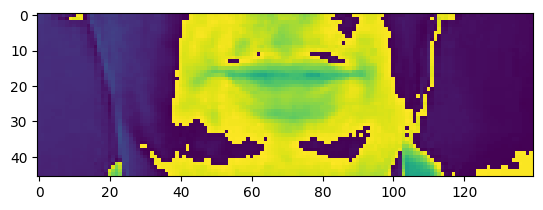

In [ ]:
plt.imshow(val[0][0][35])
# [0] for video, [0] for 1st video, [35] for 35th frame out of that video

## 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape


(75, 46, 140, 1)

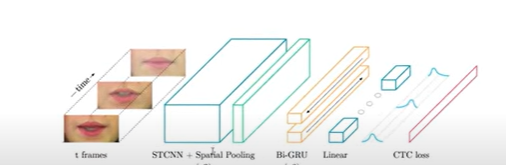


In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
# (75,46,140,1) is the shape of the frame
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten())) #preserve the 75 and flatten the rest features making 5*17*75 = 6375

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'rrrrrffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'rrrrrffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

## 4. Setup Training and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
# In summary, this learning rate scheduler keeps the learning rate constant for the first 30 epochs and then decreases it exponentially after that.
# The choice of decreasing the learning rate after a certain number of epochs can help the model converge more effectively, especially in cases where a higher learning rate may cause oscillations or overshooting during training.

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64") #length of mpg file
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64") #length of annotation

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

  # This CTC loss code has been directly taken from the research paper - https://keras.io/examples/audio/ctc_asr/#training-and-evaluating

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator() # taking out a sample from the dataset

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy() # special function to decode the prediction that are predicted using ctc loss
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100) #this would produce prediction at the end of every epoch

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
# stores the checkpoint and corresponding weights in folder called models

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)
# calling the decreasing lr scheduler

In [ ]:
example_callback = ProduceExample(test)
# produces prediction at the end

In [ ]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')
# tested- 96th checkpoint had the best accuracy, so calling that

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 129MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
sample = test_data.next()

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by m three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green at y zero now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by m three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green at y zero now'>]

### Test on Video

In [ ]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/bbaf2n.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 801ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>]

# Test for custom video

In [ ]:
# import cv2
# import base64
# import numpy as np
# from IPython.display import display, Image
# from google.colab.output import eval_js
# import io

# # Set video dimensions
# width = 140
# height = 46
# fps = 30
# frame_count = 75
# rgb_factor = 1

# # Create a VideoWriter object for MPG format
# fourcc = cv2.VideoWriter_fourcc(*'MPG1')
# out = cv2.VideoWriter('output_video.mpg', fourcc, fps, (width, height), isColor=(rgb_factor > 1))

# # Function to capture video from webcam
# def capture_video():
#     js = (
#         "var video = document.createElement('video');"
#         "document.body.appendChild(video);"
#         "navigator.mediaDevices.getUserMedia({video: true})"
#         ".then((stream) => { video.srcObject = stream; return video.play();})"
#     )
#     eval_js(js)

# # Function to display the frame in Colab
# def show_image(image):
#     _, png = cv2.imencode('.png', image)
#     display(Image(data=png.tobytes()))

# # Capture video and write frames to the video file
# capture_video()
# for i in range(frame_count):
#     # Capture a frame from the webcam
#     js = (
#         "var canvas = document.createElement('canvas');"
#         "var video = document.querySelector('video');"
#         "canvas.width = video.videoWidth;"
#         "canvas.height = video.videoHeight;"
#         "canvas.getContext('2d').drawImage(video, 0, 0);"
#     )
#     eval_js(js)

#     # Convert the base64 image data to a NumPy array
#     img_data = eval_js("canvas.toDataURL('image/jpeg').split(',')[1]")
#     img_binary = base64.b64decode(img_data)
#     frame = cv2.imdecode(np.frombuffer(img_binary, np.uint8), 1)

#     # Resize the frame to the specified dimensions
#     frame = cv2.resize(frame, (width, height))

#     # Convert the frame to grayscale if needed
#     if rgb_factor == 1:
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # Write the frame to the video file
#     out.write(frame)

#     # Display the frame in Colab
#     show_image(frame)

# # Release the VideoWriter object
# out.release()


In [ ]:
out.release()

In [ ]:
frames = load_video('/content/output_video.mpg')

<ipython-input-91-4badc1b5a215>:1: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(frames[40])


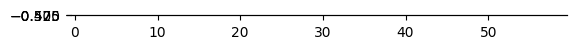

In [ ]:
plt.imshow(frames[40])

In [ ]:
frames.shape

TensorShape([75, 0, 60, 1])

In [ ]:
import cv2
from google.colab.output import eval_js
import base64
import numpy as np

# Set video dimensions
width = 140
height = 46
fps = 30
frame_count = 75

# Create a VideoWriter object for MPG format
fourcc = cv2.VideoWriter_fourcc(*'MPG1')
out = cv2.VideoWriter('output_video.mpg', fourcc, fps, (width, height), isColor=True)

# Function to capture video from webcam
def capture_video():
    js = (
        "var video = document.createElement('video');"
        "document.body.appendChild(video);"
        "navigator.mediaDevices.getUserMedia({video: true})"
        ".then((stream) => { video.srcObject = stream; return video.play();})"
    )
    eval_js(js)

# Capture video and write frames to the video file
capture_video()

try:
    for i in range(frame_count):
        # Capture a frame from the webcam
        js = (
            "var canvas = document.createElement('canvas');"
            "var video = document.querySelector('video');"
            "canvas.width = video.videoWidth;"
            "canvas.height = video.videoHeight;"
            "canvas.getContext('2d').drawImage(video, 0, 0);"
        )
        eval_js(js)

        # Convert the base64 image data to a NumPy array
        img_data = eval_js("canvas.toDataURL('image/jpeg').split(',')[1]")
        img_binary = base64.b64decode(img_data)
        frame = cv2.imdecode(np.frombuffer(img_binary, np.uint8), cv2.IMREAD_COLOR)

        # Resize the frame to the specified dimensions
        frame = cv2.resize(frame, (width, height))

        # Write the frame to the video file
        out.write(frame)

except KeyboardInterrupt:
    # Release the VideoWriter object
    out.release()
    # Release the webcam capture object
    eval_js('document.querySelector("video").srcObject.getTracks().forEach(track => track.stop());')

# Release the VideoWriter object
out.release()
# Release the webcam capture object
eval_js('document.querySelector("video").srcObject.getTracks().forEach(track => track.stop());')


In [ ]:
import cv2
from google.colab.output import eval_js
import base64
import numpy as np
from IPython.display import display, HTML

# Set video dimensions
width = 140
height = 46
fps = 30
frame_count = 75

# Create a VideoWriter object for MPG format
fourcc = cv2.VideoWriter_fourcc(*'MPG1')
out = cv2.VideoWriter('output_video.mpg', fourcc, fps, (width, height), isColor=True)

# Function to capture video from webcam
def capture_video():
    js = (
        "var video = document.createElement('video');"
        "document.body.appendChild(video);"
        "navigator.mediaDevices.getUserMedia({video: true})"
        ".then((stream) => { video.srcObject = stream; return video.play();})"
    )
    eval_js(js)

# Function to display the video in Colab
def show_live_video(video_path):
    video_content = open(video_path, "rb").read()
    video_encoded = base64.b64encode(video_content).decode("utf-8")
    video_tag = """
    <video width="{}" height="{}" controls>
        <source src="data:video/mp4;base64,{}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """.format(width, height, video_encoded)
    display(HTML(video_tag))

# Capture video and write frames to the video file
capture_video()

try:
    for i in range(frame_count):
        # Capture a frame from the webcam
        js = (
            "var canvas = document.createElement('canvas');"
            "var video = document.querySelector('video');"
            "canvas.width = video.videoWidth;"
            "canvas.height = video.videoHeight;"
            "canvas.getContext('2d').drawImage(video, 0, 0);"
        )
        eval_js(js)

        # Convert the base64 image data to a NumPy array
        img_data = eval_js("canvas.toDataURL('image/jpeg').split(',')[1]")
        img_binary = base64.b64decode(img_data)
        frame = cv2.imdecode(np.frombuffer(img_binary, np.uint8), cv2.IMREAD_COLOR)

        # Resize the frame to the specified dimensions
        frame = cv2.resize(frame, (width, height))

        # Write the frame to the video file
        out.write(frame)

        # Display the frame live in Colab
        display(Image(frame, format='jpeg'))

except KeyboardInterrupt:
    # Release the VideoWriter object
    out.release()
    # Release the webcam capture object
    eval_js('document.querySelector("video").srcObject.getTracks().forEach(track => track.stop());')

# Release the VideoWriter object
out.release()
# Release the webcam capture object
eval_js('document.querySelector("video").srcObject.getTracks().forEach(track => track.stop());')

# Display the final recorded video in Colab
show_live_video('output_video.mpg')
